# Train and test the model

In [1]:
from preprocessor import Preprocessor
import batch_generator
from keras.optimizers import Adam
import modelling
import importlib
import evaluating
import tensorflow as tf
from keras.models import Model

Using TensorFlow backend.


In [2]:
importlib.reload(batch_generator)

<module 'batch_generator' from 'C:\\Users\\dell\\Notebooks\\cv\\kostya\\batch_generator.py'>

In [3]:
train_generator = batch_generator.BatchGenerator(64, 64, mode='train')
test_generator = batch_generator.BatchGenerator(64, 64, mode='test')

In [4]:
shapes = train_generator[0]
shapes[0][0].shape, shapes[0][1].shape, shapes[0][2].shape, shapes[0][3].shape, shapes[1].shape

((128, 20), (128, 20), (128, 3), (128, 3), (128, 1))

In [5]:
shapes[0][3][:5]

array([[ 28,  19,  67],
       [ 15,  34,  30],
       [ 15,  34,  30],
       [ 24, 100,   6],
       [ 28,  19,  67]], dtype=int64)

In [ ]:
train_embedding_generator = batch_generator.BatchGenerator(64, 64, mode='train', return_stat=False)
test_embedding_generator = batch_generator.BatchGenerator(64, 64, mode='test', return_stat=False)

In [57]:
shapes = train_embedding_generator[0]
shapes[0][0].shape, shapes[0][1].shape, shapes[1].shape

((128, 20), (128, 20), (128, 1))

In [6]:
importlib.reload(modelling)

<module 'modelling' from 'C:\\Users\\dell\\Notebooks\\cv\\kostya\\modelling.py'>

In [7]:
model = modelling.Mothership_v4(20, 3, [42, 102], [2, 2],
                                20, 3, [42, 102, 102], [2, 2, 2])

In [48]:
model.compile(Adam(lr=.001), loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
model.fit_generator(train_generator, epochs=1)
model.evaluate_generator(test_generator)

Epoch 1/1


424/695 [=================>............] - ETA: 38s - loss: 0.6547 - acc: 0.64 - ETA: 28s - loss: 0.6183 - acc: 0.67 - ETA: 26s - loss: 0.6271 - acc: 0.65 - ETA: 25s - loss: 0.6337 - acc: 0.64 - ETA: 25s - loss: 0.6236 - acc: 0.65 - ETA: 24s - loss: 0.6181 - acc: 0.66 - ETA: 24s - loss: 0.6209 - acc: 0.66 - ETA: 23s - loss: 0.6212 - acc: 0.66 - ETA: 23s - loss: 0.6244 - acc: 0.65 - ETA: 23s - loss: 0.6253 - acc: 0.65 - ETA: 23s - loss: 0.6251 - acc: 0.65 - ETA: 23s - loss: 0.6215 - acc: 0.66 - ETA: 22s - loss: 0.6226 - acc: 0.66 - ETA: 22s - loss: 0.6296 - acc: 0.65 - ETA: 22s - loss: 0.6239 - acc: 0.66 - ETA: 22s - loss: 0.6249 - acc: 0.66 - ETA: 22s - loss: 0.6259 - acc: 0.65 - ETA: 22s - loss: 0.6263 - acc: 0.65 - ETA: 22s - loss: 0.6272 - acc: 0.65 - ETA: 22s - loss: 0.6336 - acc: 0.65 - ETA: 22s - loss: 0.6333 - acc: 0.65 - ETA: 22s - loss: 0.6348 - acc: 0.64 - ETA: 22s - loss: 0.6362 - acc: 0.64 - ETA: 21s - loss: 0.6428 - acc: 0.64 - ETA: 21s - loss: 0.6453 - acc: 0.63 - ETA: 21

695/695 [==============================] - ETA: 9s - loss: 0.6302 - acc: 0.651 - ETA: 9s - loss: 0.6303 - acc: 0.651 - ETA: 9s - loss: 0.6300 - acc: 0.652 - ETA: 9s - loss: 0.6302 - acc: 0.651 - ETA: 8s - loss: 0.6301 - acc: 0.651 - ETA: 8s - loss: 0.6302 - acc: 0.651 - ETA: 8s - loss: 0.6302 - acc: 0.651 - ETA: 8s - loss: 0.6302 - acc: 0.651 - ETA: 8s - loss: 0.6303 - acc: 0.651 - ETA: 8s - loss: 0.6303 - acc: 0.651 - ETA: 8s - loss: 0.6303 - acc: 0.651 - ETA: 8s - loss: 0.6302 - acc: 0.651 - ETA: 8s - loss: 0.6302 - acc: 0.652 - ETA: 8s - loss: 0.6301 - acc: 0.652 - ETA: 8s - loss: 0.6301 - acc: 0.652 - ETA: 8s - loss: 0.6302 - acc: 0.652 - ETA: 8s - loss: 0.6300 - acc: 0.652 - ETA: 8s - loss: 0.6301 - acc: 0.652 - ETA: 7s - loss: 0.6303 - acc: 0.652 - ETA: 7s - loss: 0.6301 - acc: 0.652 - ETA: 7s - loss: 0.6301 - acc: 0.652 - ETA: 7s - loss: 0.6300 - acc: 0.652 - ETA: 7s - loss: 0.6303 - acc: 0.652 - ETA: 7s - loss: 0.6301 - acc: 0.652 - ETA: 7s - loss: 0.6301 - acc: 0.652 - ETA: 7s

[0.6284160650806663, 0.6546103395061729]

In [55]:
pro_stat = Model(inputs=model.input, outputs=model.pro_stat)
output = pro_stat.predict([shapes[0][0], shapes[0][1], shapes[0][2], shapes[0][3]])

In [56]:
output[:15]

array([[ 0.00000000e+00,  0.00000000e+00,  6.69063747e-01,
        -4.17944901e-02,  3.92648339e-01, -5.15760839e-01],
       [-3.65261406e-01, -1.02516666e-01, -3.79736423e-01,
        -8.57879698e-01,  8.66405904e-01,  4.09713387e-01],
       [-3.65261406e-01, -1.02516666e-01, -3.79736423e-01,
        -8.57879698e-01,  8.66405904e-01,  4.09713387e-01],
       [-3.70357300e+03, -1.21105383e+03, -1.58665820e+03,
        -2.31051367e+03,  5.68330536e+01, -1.89314682e+02],
       [ 0.00000000e+00,  0.00000000e+00,  6.69063747e-01,
        -4.17944901e-02,  3.92648339e-01, -5.15760839e-01],
       [ 0.00000000e+00,  0.00000000e+00, -3.81764114e-01,
        -9.25687253e-01,  4.34919745e-01,  4.54266757e-01],
       [-1.10889687e+02,  2.87406128e+02, -1.09217334e+03,
         5.31833410e-01,  4.01627094e-01,  1.50385305e-01],
       [ 0.00000000e+00,  0.00000000e+00,  6.69063747e-01,
        -4.17944901e-02,  3.92648339e-01, -5.15760839e-01],
       [-1.10889687e+02,  2.87406128e+02, -1.092

In [57]:
output_1

array([[ 0.00000000e+00,  0.00000000e+00,  5.69647670e-01,
        -5.96908815e-02,  3.58425498e-01, -5.07938027e-01],
       [-3.37230414e-01, -7.85977989e-02, -3.51350099e-01,
        -8.55855465e-01,  8.32723200e-01,  3.95477414e-01],
       [-3.37230414e-01, -7.85977989e-02, -3.51350099e-01,
        -8.55855465e-01,  8.32723200e-01,  3.95477414e-01],
       [-3.77404004e+03, -1.21105420e+03, -1.58728455e+03,
        -2.31352319e+03,  1.26037216e+02, -1.06945534e+02],
       [ 0.00000000e+00,  0.00000000e+00,  5.69647670e-01,
        -5.96908815e-02,  3.58425498e-01, -5.07938027e-01],
       [ 0.00000000e+00,  0.00000000e+00, -3.15227300e-01,
        -9.05396044e-01,  3.63182783e-01,  4.04471099e-01],
       [-4.29151497e+01,  2.87404419e+02, -1.01326538e+03,
         5.34731925e-01, -9.53404382e-02,  2.05482960e-01],
       [ 0.00000000e+00,  0.00000000e+00,  5.69647670e-01,
        -5.96908815e-02,  3.58425498e-01, -5.07938027e-01],
       [-4.29151497e+01,  2.87404419e+02, -1.013

In [53]:
output_1 = output

In [ ]:
model.embedding_model.compile(Adam(lr=.01), loss='binary_crossentropy', metrics=['accuracy'])
model.embedding_model.fit_generator(train_embedding_generator, epochs=1)
model.embedding_model.evaluate_generator(test_embedding_generator)

---

# Analyze model mistakes

In [20]:
import numpy as np

In [21]:
predictions = model.predict_generator(test_generator)

In [22]:
preds = np.round(predictions).reshape(-1)
preds

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [23]:
preds.shape

(10368,)

In [25]:
true_block = np.concatenate([np.ones(64), np.zeros(64)])
true = np.tile(true_block, 81)
true.shape

(10368,)

In [26]:
print('Accuracy:', np.mean(preds == true))

Accuracy: 0.6655092592592593


In [27]:
true_positive = preds[(true == 1) & (preds == 1)].shape[0]
pred_positive = preds[preds == 1].shape[0]
precision = true_positive / pred_positive
print('Precision:', precision)

Precision: 0.6585365853658537


In [28]:
true_positive = preds[(true == 1) & (preds == 1)].shape[0]
actual_positive = true[true == 1].shape[0]
recall = true_positive / actual_positive
print('Recall:', recall)

Recall: 0.6875


---

# Visualize Embedding layer

In [46]:
model.get_layer('categorizer_2').get_layer('embedding_5').get_weights()

[array([[-8.83600533e-01, -1.89428240e-01],
        [-1.27126013e+03,  9.51083618e+02],
        [-7.39795983e-01,  6.43788725e-02],
        [ 3.41479719e-01,  1.82593060e+00],
        [ 1.93636194e-01,  1.03518233e-01],
        [ 3.07542402e-02,  2.83586979e+01],
        [-3.81284505e-01, -9.23634991e-02],
        [-4.43538025e+02, -5.58229590e+03],
        [ 1.17785156e+03,  4.35326584e-02],
        [ 4.64801677e-02,  4.12007421e-01],
        [ 4.92679104e-02,  1.40640405e+03],
        [ 1.11298583e-01,  1.14572495e-01],
        [-4.40546274e-01,  5.92285953e-02],
        [-3.74839276e-01, -4.35490131e-01],
        [ 3.99724245e-01,  4.28107172e-01],
        [ 1.65311928e+01, -2.24864292e+01],
        [ 5.87803040e+02, -1.23754285e+03],
        [ 7.79838806e+02,  4.22294373e+02],
        [ 7.49624023e+01, -3.31433936e+03],
        [ 1.09912500e-01,  1.70754433e-01],
        [ 2.99531281e-01,  5.78141212e-01],
        [ 7.16293633e-01, -8.22987780e-03],
        [ 8.10566425e-01,  7.382

In [54]:
importlib.reload(evaluating)

<module 'evaluating' from 'C:\\Users\\dell\\Notebooks\\cv\\kostya\\evaluating.py'>

In [61]:
import pickle
with open('preprocessors.pickle', 'rb') as f:
    preproc = pickle.load(f)

preproc['professionals_state'].classes_

array(['Arizona', 'Brazil', 'California', 'Canada', 'China',
       'Connecticut', 'Dallas/Fort Worth Area', 'Delaware', 'Florida',
       'Florida Area', 'Georgia', 'Greater Atlanta Area',
       'Greater Boston Area', 'Greater Chicago Area',
       'Greater Los Angeles Area', 'Greater New York City Area',
       'Greater Philadelphia Area', 'Greater Seattle Area', 'Illinois',
       'India', 'Indiana', 'Indiana Area', 'Maryland', 'Massachusetts',
       'Michigan', 'New Jersey', 'New York', 'North Carolina', 'Ohio',
       'Oregon', 'Pennsylvania', 'San Francisco Bay Area', 'Tennessee',
       'Texas', 'Texas Area', 'United Kingdom', 'United States',
       'Virginia', 'Washington', 'Washington D.C. Metro Area'],
      dtype=object)

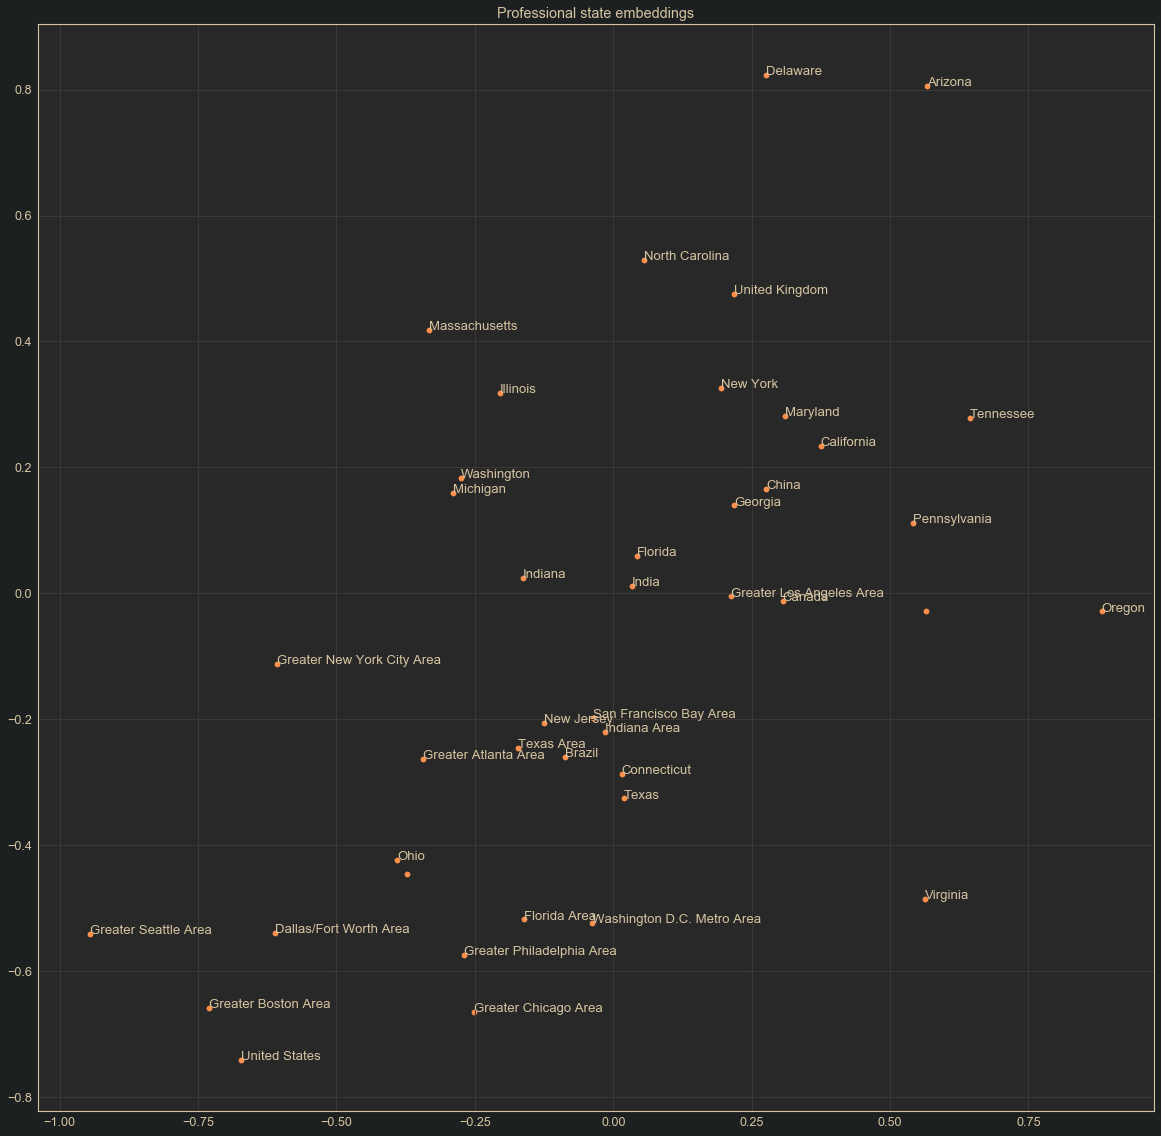

In [62]:
evaluating.vis_emb(model.get_layer('categorizer_4'), 'embedding_10',
                   preproc['professionals_state'].classes_, (20, 20), 'y', 'Professional state embeddings')

---

# Compute feature importance

In [29]:
fn = {
  "que_stat": [
    "students_state",
    "students_location",
      
#     "students_questions_asked",
#     "students_average_question_age",
#     "students_average_question_body_length",
#     "students_average_answer_body_length",
#     "students_date_joined_time",
#     "students_date_joined_doy_sin",
#     "students_date_joined_doy_cos",
#     "students_date_joined_dow",
      
    "questions_body_length",
      
#     "questions_date_added_time",
#     "questions_date_added_doy_sin",
#     "questions_date_added_doy_cos",
#     "questions_date_added_dow",
#     "questions_date_added_hour_sin",
#     "questions_date_added_hour_cos",
#     "questions_current_time",
  ],
  "pro_stat": [
    "professionals_state",
    "professionals_location",
    "professionals_industry",
      
#     "professionals_questions_answered",
#     "professionals_average_question_age",
#     "professionals_average_question_body_length",
#     "professionals_average_answer_body_length",
#     "professionals_email_activated",
#     "professionals_date_joined_time",
#     "professionals_date_joined_doy_sin",
#     "professionals_date_joined_doy_cos",
#     "professionals_date_joined_dow",
#     "professionals_last_answer_date_time",
#     "current_time"
  ]
}

In [30]:
fn['stat'] = fn['que_stat'] + fn['pro_stat']

In [31]:
fn['que_emb'] = [f'que_emb_{i}' for i in range(10)]
fn['que_emb'] += [f'que_tag_emb_{i}' for i in range(10)]
# fn['que_emb'] += [f'stu_tag_emb_{i}' for i in range(10)]

In [32]:
fn['pro_emb'] = [f'ind_emb_{i}' for i in range(10)]
fn['pro_emb'] += [f'pro_tag_emb_{i}' for i in range(10)]

In [33]:
len(fn['que_stat']), len(fn['pro_stat'])

(3, 3)

In [34]:
train_batch_generator = batch_generator.BatchGenerator(1024, 1024, mode='train')

In [35]:
test_batch_generator = batch_generator.BatchGenerator(1024, 1024, mode='test')

In [36]:
from jupyterthemes import jtplot
jtplot.style('gruvboxd')

In [37]:
importlib.reload(evaluating)

<module 'evaluating' from 'C:\\Users\\dell\\Notebooks\\cv\\kostya\\evaluating.py'>

In [58]:
fi = evaluating.permutation_importance(model, train_batch_generator[0][0], train_batch_generator[0][1], fn)

Test
2048/2048 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 93us/step


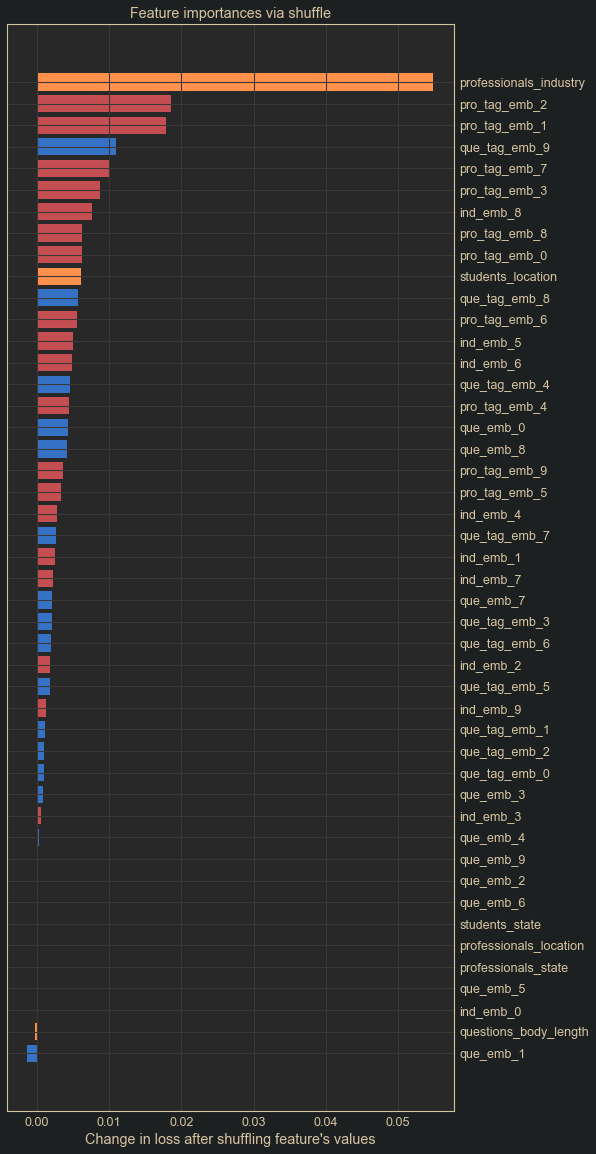

In [59]:
evaluating.plot_fi(fi, fn)

In [60]:
fi = evaluating.permutation_importance(model, test_batch_generator[0][0], test_batch_generator[0][1], fn)

Test
2048/2048 [==============================] - ETA:  - ETA:  - ETA:  - 0s 74us/step


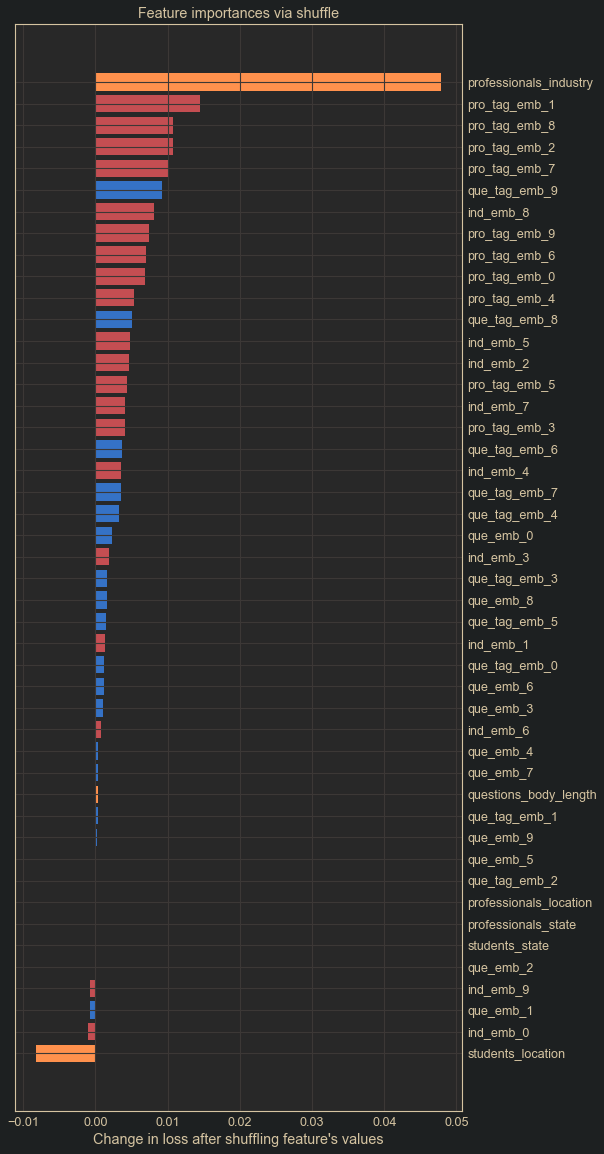

In [61]:
evaluating.plot_fi(fi, fn)